In [1]:
import re
import time
import json
import csv
import random
import requests
import pprint
import pickle
import unidecode
import numpy as np
import pandas as pd
from random import sample
import reverse_geocode
import seaborn as sns
import scipy.stats as stat
from sklearn import metrics
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chisquare
from collections import Counter, defaultdict
from sklearn.metrics import cohen_kappa_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
Data_Root = '/Data/Promotion/revision/'

In [3]:
def yield_one_line(filename, delimiter = '\t', quote = csv.QUOTE_NONE):
    '''a generator which produce one line of a given file'''
    with open(filename, 'r') as file:
        print('processing %s...' %(filename))
        reader = csv.reader(file, delimiter=delimiter, quoting=quote)
        for row in reader:
            yield row

In [4]:
utype = {'author_id': str, 'matched_tid': 'str', 'matched_tid_original': 'str', 'matched_tid_retweet': 'str'}
reg_data = pd.read_csv(Data_Root+"reg_data_drop_missing.csv", header=0, dtype=utype)

In [5]:
len(reg_data)

14552304

In [6]:
# focus on Male and Female
reg_data = reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])]
reg_data.index = range(len(reg_data))

In [7]:
len(reg_data)

11420039

In [8]:
reg_data = reg_data.loc[reg_data['affiliation_cate'] != 'unknown']
reg_data.index = range(len(reg_data))

In [9]:
len(reg_data)

11396752

In [10]:
reg_data.head(3)

,doi,pub_year,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,matched_tid_original,self_promotion_retweet,...,author_eth_ethnea_broad,pub_date,is_active_on_twitter,follower_cn_snapshot,matched_uid,is_active_on_twitter_ours,follower_cn_snapshot_ours,is_active_on_twitter_combine,follower_cn_snapshot_combine,self_promotion_first
0,10.4202/app.00261.2016,2016,Michal Zaton,2,last_position,2064717215,864159182,False,NaN,False,...,EasternEuropean,2016-01-01,False,-1,NaN,False,-1,False,-1,False
1,10.1016/j.foodchem.2013.11.152,2014,He Li,3,middle_position,2569941301,4750791,False,NaN,False,...,Chinese,2014-06-01,False,-1,NaN,False,-1,False,-1,False
2,10.1145/2785956.2787504,2015,Omid Abari,1,first_position,27058069,63966007,False,NaN,False,...,MiddleEastern,2015-09-22,False,-1,NaN,False,-1,False,-1,False


In [11]:
len(reg_data.loc[~reg_data.matched_tid.isnull()])

480622

In [12]:
len(reg_data.loc[reg_data.self_promotion == True])

480622

In [13]:
reg_data = reg_data.loc[reg_data.self_promotion == True]
reg_data.index = range(len(reg_data))

In [14]:
len(reg_data)

480622

In [15]:
len(reg_data.loc[reg_data.matched_tid.isnull()])

0

In [16]:
reg_data['gender'].value_counts()

Male      340781
Female    139841
Name: gender, dtype: int64

In [17]:
target_tids = set(reg_data['matched_tid'].tolist())

In [18]:
len(target_tids)

465323

In [19]:
tid_text = {}

with open('/Data/Promotion/tweets_v2.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid, tdate, text = line['id_str'], line['created_at'], line['full_text']
        if tid in target_tids:
            tid_text[tid] = text

In [20]:
len(tid_text)

460906

In [21]:
reg_data = reg_data.loc[reg_data.matched_tid.isin(tid_text)]
reg_data.index = range(len(reg_data))

In [22]:
reg_data['gender'].value_counts()

Male      337230
Female    138666
Name: gender, dtype: int64

In [23]:
analyzer = SentimentIntensityAnalyzer()

In [24]:
event_sen_count = defaultdict(lambda: defaultdict(int))

for tid in reg_data.loc[reg_data['gender'] == 'Male']['matched_tid']:
    if tid in tid_text:
        res = analyzer.polarity_scores(tid_text[tid])
        comp = res['compound']
        sen_label = "Neu."
        if comp < -0.05:
            sen_label = "Neg."
        if comp > 0.05:
            sen_label = "Pos."
        event_sen_count[sen_label]['Male'] += 1
        
for tid in reg_data.loc[reg_data['gender'] == 'Female']['matched_tid']:
    if tid in tid_text:
        res = analyzer.polarity_scores(tid_text[tid])
        comp = res['compound']
        sen_label = "Neu."
        if comp < -0.05:
            sen_label = "Neg."
        if comp > 0.05:
            sen_label = "Pos."
        event_sen_count[sen_label]['Female'] += 1

In [25]:
sen_df = pd.DataFrame.from_dict(event_sen_count)

In [26]:
sen_df

,Neu.,Pos.,Neg.
Male,156282,128127,52821
Female,60396,56853,21417


In [27]:
sen_df.div(sen_df.sum(axis=1), axis=0)

,Neu.,Pos.,Neg.
Male,0.463429,0.37994,0.156632
Female,0.435550,0.41000,0.154450


In [28]:
g, p, dof, expctd = stat.chi2_contingency(sen_df)

In [29]:
p

2.107303027211385e-87

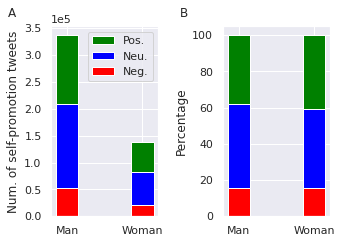

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3.5))

# ax1
ax = axes[0]
sns.set(font_scale=1)
# categories = sen_df.index.tolist()
categories = ['Man', 'Woman']

neg_count = sen_df['Neg.'].values
neu_count = sen_df['Neu.'].values
pos_count = sen_df['Pos.'].values

p1 = ax.bar(categories, neg_count, 0.3, color='red')
p2 = ax.bar(categories, neu_count, 0.3, color='blue', bottom = neg_count)
p3 = ax.bar(categories, pos_count, 0.3, color='green', bottom = neg_count + neu_count)
ax.legend((p3[0], p2[0], p1[0]), ('Pos.', 'Neu.', 'Neg.'))
ax.set_ylabel(r'Num. of self-promotion tweets')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))
ax.text(-0.4, 1.1, 'A', fontsize=12, ha='left', va='top', transform=ax.transAxes)

# ax2
# Plots the bar chart
# bar_width = 1
bar_l = [i for i in range(len(sen_df))] 
totals = sen_df.sum(axis=1).tolist()
pos_rel = sen_df['Pos.'] * 100 / totals
neu_rel = sen_df['Neu.'] * 100 / totals
neg_rel = sen_df['Neg.'] * 100 / totals

ax = axes[1]
p1 = ax.bar(categories, neg_rel, 0.3, color='red')
p2 = ax.bar(categories, neu_rel, 0.3, color='blue', bottom = neg_rel)
p3 = ax.bar(categories, pos_rel, 0.3, color='green', bottom = neg_rel + neu_rel)

ax.set_ylabel("Percentage")
ax.set_xlabel("")
# ax.legend(loc='right', fontsize = 10, frameon = False, ncol=1)
# plt.setp(plt.gca().get_xticklabels(), rotation=15, horizontalalignment='right')
# ax.set_xlim([min(bar_l)-bar_width, max(bar_l)+bar_width])
ax.set_ylim(0, 105)
ax.text(-0.4, 1.1, 'B', fontsize=12, ha='left', va='top', transform=ax.transAxes)


plt.subplots_adjust(wspace=0.6)
plt.show()
fig.savefig("sentiment.pdf", bbox_inches='tight', pad_inches=0)

In [31]:
#'favorable',
#'favourable',
pos_words = ['amazing',
 'assuring',
 'astonishing',
 'bright',
 'creative',
 'encouraging',
 'enormous',
 'excellent',
 'favorable',
 'groundbreaking',
 'hopeful',
 'innovative',
 'inspiring',
 'inventive',
 'novel',
 'phenomenal',
 'prominent',
 'promising',
 'reassuring',
 'remarkable',
 'robust',
 'spectacular',
 'supportive',
 'unique',
 'unprecedented']

In [32]:
len(pos_words)

25

In [33]:
def check_word_occur(tid, word):
    sss_ = tid_text[tid].lower()
    if word in sss_:
        return 1
    else:
        return 0

In [34]:
for word in pos_words:
    reg_data[word] = reg_data['matched_tid'].apply(lambda tid: check_word_occur(tid, word))

In [35]:
for word in pos_words:
    tem_df = pd.crosstab(reg_data[word], reg_data['gender'])
    tem_df = tem_df.div(tem_df.sum(axis=0), axis=1)
    print(word, '\n')
    print(tem_df)
    print()

amazing 

gender     Female      Male
amazing                    
0        0.996344  0.997011
1        0.003656  0.002989

assuring 

gender      Female      Male
assuring                    
0         0.999921  0.999923
1         0.000079  0.000077

astonishing 

gender         Female      Male
astonishing                    
0            0.999935  0.999938
1            0.000065  0.000062

bright 

gender    Female      Male
bright                    
0       0.999228  0.999244
1       0.000772  0.000756

creative 

gender      Female      Male
creative                    
0         0.999344  0.999534
1         0.000656  0.000466

encouraging 

gender         Female      Male
encouraging                    
0            0.999856  0.999772
1            0.000144  0.000228

enormous 

gender      Female      Male
enormous                    
0         0.999885  0.999887
1         0.000115  0.000113

excellent 

gender       Female      Male
excellent                    
0          0.9967

In [36]:
colors = sns.color_palette()[:2]

In [37]:
plot_data = []

for word in pos_words:
    perc = reg_data[word].sum()/len(reg_data)
    male_seq = reg_data.loc[reg_data['gender'] == 'Male'][word]
    female_seq = reg_data.loc[reg_data['gender'] == 'Female'][word]
    if np.mean(male_seq) >= np.mean(female_seq):
        color = colors[0]
        _, p_u = stat.mannwhitneyu(male_seq, female_seq, alternative='greater')
    else:
        color = colors[1]
        _, p_u = stat.mannwhitneyu(male_seq, female_seq, alternative='less')
    star = ''
    if p_u < 0.001:
        star = '***'
    elif p_u < 0.01:
        star = '**'
    elif p_u < 0.05:
        star = '*'
    plot_data.append([word, perc, color, star])

In [38]:
plot_data = sorted(plot_data, key = lambda x: -1 * x[1])

In [39]:
for word, perc, color, star in plot_data:
    print('%.5f'%perc, word, star)

0.00698 novel ***
0.00362 excellent **
0.00318 amazing ***
0.00154 robust ***
0.00130 unique 
0.00091 hopeful *
0.00085 promising *
0.00081 innovative **
0.00076 bright 
0.00052 creative **
0.00040 remarkable ***
0.00034 supportive ***
0.00020 encouraging *
0.00020 favorable **
0.00018 unprecedented **
0.00018 inspiring *
0.00014 groundbreaking 
0.00012 prominent 
0.00011 enormous 
0.00009 spectacular 
0.00008 phenomenal 
0.00008 assuring 
0.00006 astonishing 
0.00006 reassuring 
0.00003 inventive *


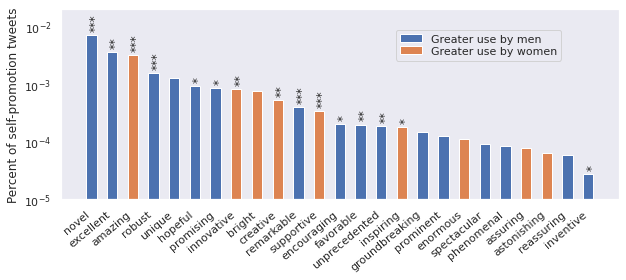

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3.5))

xs_1, percs_1, color_1 = [], [], []
xs_2, percs_2, color_2 = [], [], []

for i in range(len(plot_data)):
    word, perc, color, star = plot_data[i]
    if color == colors[0]:
        xs_1.append(i)
        percs_1.append(perc)
        color_1.append(color)
    else:
        xs_2.append(i)
        percs_2.append(perc)
        color_2.append(color)
ax.bar(xs_1, percs_1, 0.5, color=color_1, label='Greater use by men')
ax.bar(xs_2, percs_2, 0.5, color=color_2, label='Greater use by women')
legend = ax.legend(loc=[0.6, 0.73], numpoints=2, labelspacing = 0.2, shadow=False, frameon = True)

words_ = [word for word, perc, color, star in plot_data]

for i in range(len(plot_data)):
    word, perc, color, star = plot_data[i]
    ax.annotate(star, xy=(i, perc), xycoords='data', xytext=(3.5, 4), textcoords='offset points', \
                ha='center', va='bottom', rotation=90)
ax.set_ylabel("Percent of self-promotion tweets")
ax.set_xticks(list(range(len(words_))))
ax.set_xticklabels(words_)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(40)
ax.set_yscale('log')
ax.set_ylim(0.00001, 0.02)
ax.grid(visible=False)
# ax.set_facecolor('white')
# ax.spines['right'].set_visible(True)
# ax.spines['left'].set_visible(True)
# ax.spines['top'].set_visible(True)
# ax.spines['bottom'].set_visible(True)
plt.show()
fig.savefig("pos_word.pdf", bbox_inches='tight', pad_inches=0)